# Sensitivity Analysis

In this tutorial we demonstrate how to perform sensitivity analysis as part of the `AutoEmulate` workflow. The tutorial covers:

1. Setting up an example simulation: here we use our "FlowProblem" simulator. This is a cardiovascular modelling example, simulating a blood vessel divided into 10 compartments. This allows for the study of the pressure and flow rate at various points in the tube. See "The Flow Problem" below for more details.
2. Running the simulation for 100 sets of parameters sampled from the parameter space.
3. Using Autoemulate to find the best emulator for this simulation
4. Performing sensitivity analysis.

<details>
<summary>The Flow Problem</summary>

In the field of cardiovascular modeling, capturing the dynamics of blood flow and the associated pressures and volumes within the vascular system is crucial for understanding heart function and disease. This simulator simulates a vessel divided to 10 compartments.

### Parameters

The simulation parameters include :

1. R (Resistance):
   Represents the resistance to blood flow in blood vessels, akin to the hydraulic resistance caused by vessel diameter and blood viscosity (Analogous to electrical resistor).
2. L (Inductance):
   Represents the inertial effects of blood flow, capturing how blood resists changes in its velocity (Analogous to electrical inductor).
3. C (Capacitance):
   Represents the compliance or elasticity of blood vessels, primarily large arteries, which store and release blood volume with changes in pressure (Analogous to a capacitor).

### Boundary conditions

1. Neumann boundary condition : Specifies the derivative of the variable at the boundary.
2. Dirichlet Boundary condition : Specifies the value of the variable directly at the boundary.

### The setup

The input flow rate in each compartment is $Q_i(t)$ for the $i^{th}$ compartment and the output flow rate is $Q_{i+1}(t)$.

$Q_0(t) = 
\begin{cases} 
A \cdot \sin^2\left(\frac{\pi}{t_d} t\right), & \text{if } 0 \leq t < T, \\
0, & \text{otherwise}.
\end{cases}$

Where:

- $Q_0(t)$ is the input pulse function (flow rate) at time t
- A is the amplitude of the pulse
- $t_d$ is the pulse duration.

### Solve

Pressure in Each Compartment ($P_i$): This determines how the pressure in each compartment evolves over time, based on the inflow ($Q_i(t)$) and the outflow ($Q_{i+1}(t)$). where $i$ is the number of compartment.

<img src="../../../../misc/circuit.jpg" alt="Circuit Diagram" style="width:60%;"/>

$\frac{dP_i}{dt} = \frac{1}{C_n} \left( Q_i(t) - Q_{i+1}(t) \right)$ where, $C_n = \frac{C}{n_\text{comp}}$

Flow rate equation ($Q_i$): This governs how the flow in each compartment changes over time, depending on the pressures in the neighboring compartments and the resistance and inertance properties of each compartment.

$\frac{dQ_i}{dt} = \frac{1}{L_n} \left( P_i - P_{10} - R_n Q_i(t) \right)$, where $L_n = \frac{L}{n_\text{comp}}, \quad R_n = \frac{R}{n_\text{comp}}$

</details>


In [1]:
from autoemulate.core.compare import AutoEmulate
from autoemulate.core.sensitivity_analysis import SensitivityAnalysis
from autoemulate.simulations.flow_problem import FlowProblem
import warnings
warnings.filterwarnings("ignore")
figsize = (9, 5)

Set up the simulation parameters and ranges:


In [2]:
parameters_range = {
    "T": (0.5, 2.0), # Cardiac cycle period (s)
    "td": (0.1, 0.5), # Pulse duration (s)
    "amp": (100.0, 1000.0), # Amplitude (e.g., pressure or flow rate)
    "dt": (0.0001, 0.01), # Time step (s)
    "C": (20.0, 60.0), # Compliance (unit varies based on context)
    "R": (0.01, 0.1), # Resistance (unit varies based on context)
    "L": (0.001, 0.005), # Inductance (unit varies based on context)
    "R_o": (0.01, 0.05), # Outflow resistance (unit varies based on context)
    "p_o": (5.0, 15.0) # Initial pressure (unit varies based on context)
}
output_names = ["pressure"]

simulator = FlowProblem(
    parameters_range=parameters_range,
    output_names=output_names,
    log_level="error"
)

Run the simulation for 100 sets of parameters sampled from the parameter space:


In [3]:
x = simulator.sample_inputs(100)
y = simulator.forward_batch(x)

In [4]:
print(x.shape, y.shape)

torch.Size([100, 9]) torch.Size([100, 1])


Use AutoEmulate to find the best emulator for this simulation:


In [5]:
ae = AutoEmulate(x, y, models=["MLP", "GP"], log_level="error")  # remove models argument to use all models
best = ae.best_result()
print(best.model_name)

GaussianProcess


### Sensitivity Analysis

1. Define the problem by creating a dictionary which contains the names and the boundaries of the parameters
2. Evaluate the contribution of each parameter via the Sobol and Morris methods.


In [7]:
problem = {
    'num_vars': simulator.in_dim,
    'names': simulator.param_names,
    'bounds': simulator.param_bounds,
    'output_names': simulator.output_names,
}
sa = SensitivityAnalysis(best.model, problem=problem)

Sobol metrics:

- $S_1$: First-order sensitivity index.
- $S_2$: Second-order sensitivity index.
- $S_t$: Total sensitivity index.

Sobol interpretation:

- $S_1$ values sum to ≤ 1.0 (exact fraction of variance explained)
- $S_t - S_1$ = interaction effects involving that parameter
- Large $S_t - S_1$ gap indicates strong interactions


In [8]:
sobol_df = sa.run("sobol")
sobol_df

9


,output,parameter,index,value,confidence
0,pressure,T,S1,0.001006,0.000113
1,pressure,td,S1,0.030003,0.005078
2,pressure,amp,S1,0.936292,0.061902
3,pressure,dt,S1,0.000240,0.000034
4,pressure,C,S1,0.013376,0.002572
5,pressure,R,S1,0.034718,0.003928
6,pressure,L,S1,0.000615,0.000086
7,pressure,R_o,S1,0.000237,0.000033
8,pressure,p_o,S1,0.000357,0.000054
0,pressure,T,ST,0.000727,0.002581


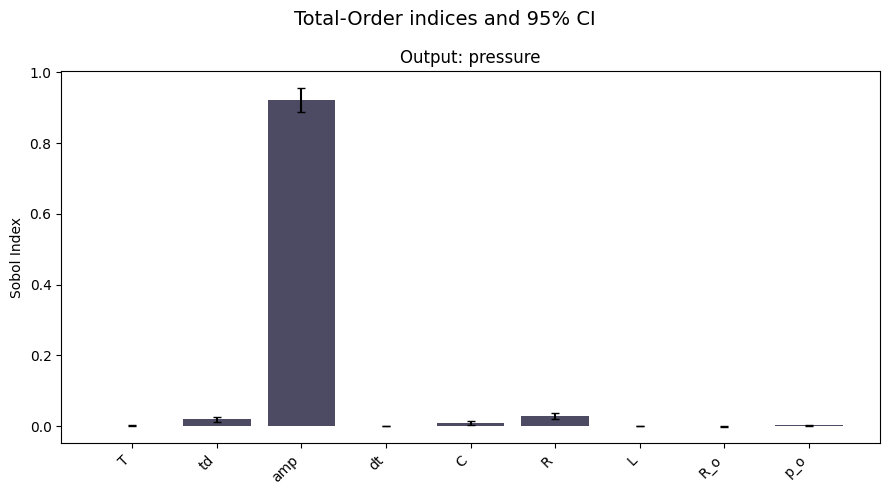

In [9]:
sa.plot_sobol(sobol_df, index="ST", figsize=figsize) 

Morris Interpretation:

- High $\mu^*$, Low $\sigma$: Important parameter with linear/monotonic effects
- High $\mu^*$, High $\sigma$: Important parameter with non-linear effects or interactions
- Low $\mu^*$, High $\sigma$: Parameter involved in interactions but not individually important
- Low $\mu^*$, Low $\sigma$: Unimportant parameter


In [10]:
morris_df = sa.run("morris")
morris_df

,output,parameter,mu,mu_star,sigma,mu_star_conf
0,pressure,T,-27.318108,27.318527,10.907842,0.651203
1,pressure,td,121.069527,121.246422,93.881798,5.429651
2,pressure,amp,706.395691,706.395691,94.652916,5.882958
3,pressure,dt,13.566430,14.735089,12.190992,0.672821
4,pressure,C,-78.900116,78.959541,66.961922,4.094789
5,pressure,R,-128.435150,128.435150,63.334797,4.180365
6,pressure,L,6.757327,15.614141,17.711409,0.681918
7,pressure,R_o,-13.646235,14.626594,10.497454,0.589090
8,pressure,p_o,-10.886688,11.635717,10.960164,0.655357


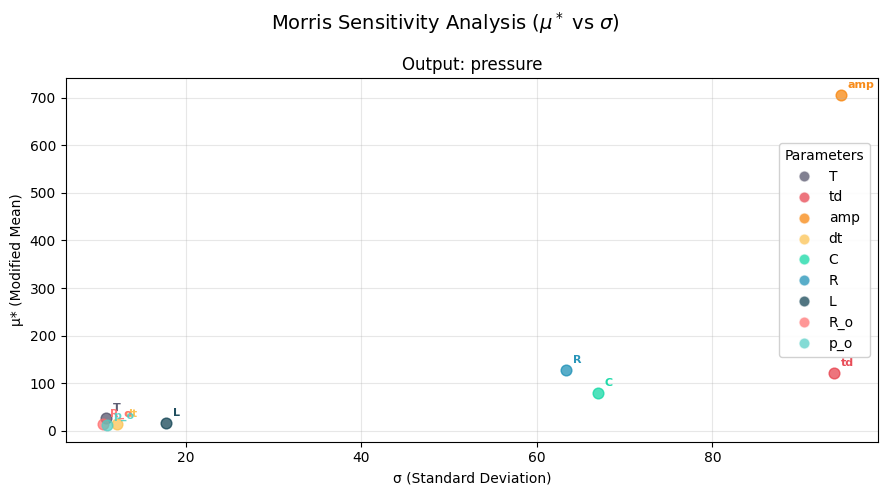

In [11]:
sa.plot_morris(morris_df, figsize=figsize)